# Load books and descriptions into python

In [95]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [96]:
directory="goodreads-data/books"
books = {}

In [97]:
for filename in os.listdir(directory):
    if filename.endswith('.json'):  # Check if the file is a JSON file
        filepath = os.path.join(directory, filename)
        
        # Open and read the JSON file
        with open(filepath, 'r') as file:
            try:
                data = json.load(file)  # Load the JSON data
                print(f"Contents of {filename}:")
                print(data)
                books[data['book_title']] = data['book_description']

            except json.JSONDecodeError as e:
                print(f"Error reading {filename}: {e}")

Contents of 61439040-1984.json:
{'book_id_title': '61439040-1984', 'book_id': '61439040', 'book_title': '1984', 'book_description': "A masterpiece of rebellion and imprisonment where war is peace freedom is slavery and Big Brother is watching. Thought Police, Big Brother, Orwellian - these words have entered our vocabulary because of George Orwell's classic dystopian novel 1984. The story of one man's Nightmare Odyssey as he pursues a forbidden love affair through a world ruled by warring states and a power structure that controls not only information but also individual thought and memory 1984 is a prophetic haunting tale More relevant than ever before 1984 exposes the worst crimes imaginable the destruction of truth freedom and individuality. With a foreword by Thomas Pynchon. This beautiful paperback edition features deckled edges and french flaps a perfect gift for any occasionAlternate cover edition can be found here.", 'book_url': 'https://www.goodreads.com/book/show/61439040-198

## Sucessfully loaded book titles and descriptions

In [98]:
len(books)

105

# Tokenize descriptions

In [99]:
import spacy

# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')


In [100]:
# Function to process descriptions
def process_description(description):
    
    # Process the text
    doc = nlp(description)
        
    # Extract lemmas of non-stop words
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    return lemmas

In [101]:
tokenized_descriptions = {}
for i in books:
    tokenized_descriptions[i] = process_description(books[i])

tokenized_descriptions.values()
    

dict_values([['masterpiece', 'rebellion', 'imprisonment', 'war', 'peace', 'freedom', 'slavery', 'Big', 'Brother', 'watch', 'Thought', 'Police', 'Big', 'Brother', 'Orwellian', 'word', 'enter', 'vocabulary', 'George', 'Orwell', 'classic', 'dystopian', 'novel', 'story', 'man', 'Nightmare', 'Odyssey', 'pursue', 'forbidden', 'love', 'affair', 'world', 'rule', 'war', 'state', 'power', 'structure', 'control', 'information', 'individual', 'thought', 'memory', 'prophetic', 'haunt', 'tale', 'relevant', 'expose', 'bad', 'crime', 'imaginable', 'destruction', 'truth', 'freedom', 'individuality', 'foreword', 'Thomas', 'Pynchon', 'beautiful', 'paperback', 'edition', 'feature', 'deckle', 'edge', 'french', 'flap', 'perfect', 'gift', 'occasionalternate', 'cover', 'edition', 'find'], ['book', 'Magnificent', 'Dune', 'Chronicles', 'Bestselling', 'Science', 'Fiction', 'Adventure', 'TimeDune', 'Messiah', 'continue', 'story', 'Paul', 'Atreides', 'well', 'know', 'fear', 'man', 'christen', 'Emperor', 'Known', '

In [102]:
descriptions = tokenized_descriptions

# Convert the dictionary into a format compatible with TfidfVectorizer
titles = list(descriptions.keys())
descriptions_as_strings = [' '.join(lemmas) for lemmas in descriptions.values()]

def vectorize_text(description):
    """Return a Tf-Idf sparse matrix """
    # Initialize the TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Compute TF-IDF scores
    tfidf_matrix = vectorizer.fit_transform(description)

    # Get feature names (unique terms)
    terms = vectorizer.get_feature_names_out()
    return tfidf_matrix.todense(), terms, tfidf_matrix

tfidf_dense, terms, tfidf_matrix = vectorize_text(descriptions_as_strings)

# Process each description
top_words_per_description = []
for i, desc_scores in enumerate(tfidf_dense):
    # Create a dictionary of term:score pairs
    term_scores = {term: score for term, score in zip(terms, desc_scores.tolist()[0])}
    
    # Get the top 15 terms sorted by TF-IDF score
    top_terms = sorted(term_scores.items(), key=lambda x: x[1], reverse=True)[:15]
    
    # Store the title and top terms
    top_words_per_description.append({
        "title": titles[i],
        "top_words": top_terms
    })

# Display the results
for book in top_words_per_description:
    print(f"Title: {book['title']}")
    print("Top 15 TF-IDF Words:")
    for word, score in book["top_words"]:
        print(f"  {word}: {score:.4f}")
    print()

Title: 1984
Top 15 TF-IDF Words:
  freedom: 0.2393
  thought: 0.2393
  brother: 0.2125
  big: 0.2030
  edition: 0.1624
  war: 0.1624
  affair: 0.1303
  deckle: 0.1303
  dystopian: 0.1303
  forbidden: 0.1303
  foreword: 0.1303
  french: 0.1303
  imprisonment: 0.1303
  individuality: 0.1303
  occasionalternate: 0.1303

Title: Dune Messiah
Top 15 TF-IDF Words:
  paul: 0.3411
  atreides: 0.2274
  house: 0.1831
  assume: 0.1394
  bestselling: 0.1394
  chani: 0.1394
  christen: 0.1394
  conduct: 0.1394
  conspiracy: 0.1394
  crumble: 0.1394
  enmity: 0.1394
  fremens: 0.1394
  icon: 0.1394
  known: 0.1394
  lover: 0.1394

Title: Spider-Man: Blue
Top 15 TF-IDF Words:
  fall: 0.2390
  love: 0.2390
  stacy: 0.2357
  spider: 0.2261
  gwen: 0.2165
  man: 0.2055
  rest: 0.2028
  life: 0.1999
  spend: 0.1922
  parker: 0.1644
  peter: 0.1594
  story: 0.1199
  appropriately: 0.1178
  daredevil: 0.1178
  eisner: 0.1178

Title: The Lightning Thief
Top 15 TF-IDF Words:
  percy: 0.3684
  camp: 0.2198
  d

# Write Found keywords to csv

In [103]:
final_write = []

for i in top_words_per_description:
    for j in i['top_words']:
        final_write.append([i['title'], j[0], j[1]])
        
df = pd.DataFrame(final_write, columns=['Title', 'Word', 'Score'])
df.to_csv('top_keywords.csv', index=False)

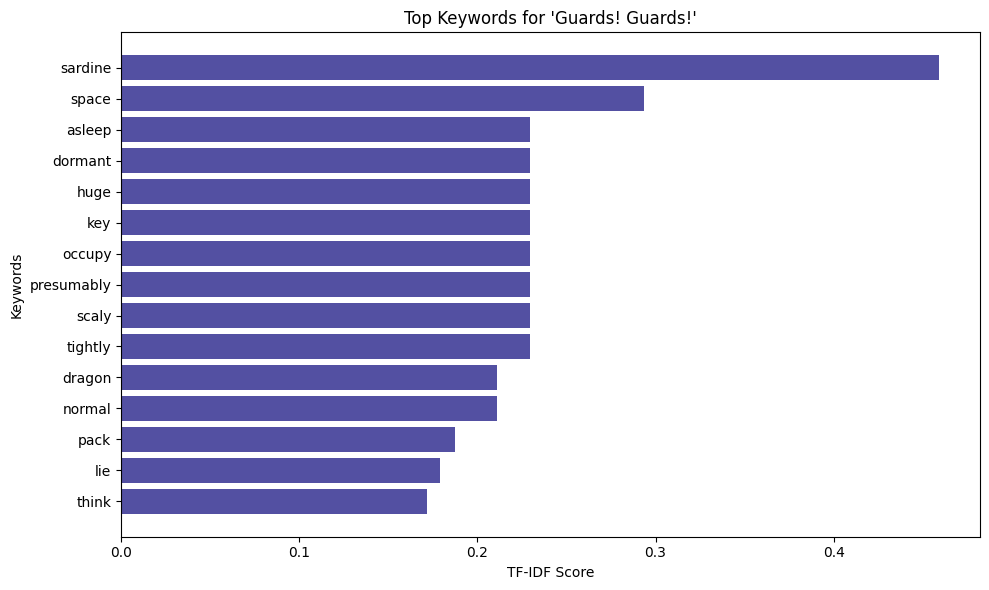

In [104]:
# Visualization
title = np.random.choice(df['Title'].unique().tolist())

def plot_book(title, df):
    """Given a book title, plot tf idf graph"""
    # Filter the top keywords for the current book
    book_keywords = df[df["Title"] == title]

    # Plot the keywords
    plt.figure(figsize=(10, 6))
    plt.barh(book_keywords["Word"], book_keywords["Score"], color="#5350a2")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Keywords")
    plt.title(f"Top Keywords for '{title}'")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.tight_layout()
    
    plt.savefig('book.png', transparent = True)
    plt.show()

fig = plot_book(title, df)

# Most Characteristic Words

In [105]:
from collections import defaultdict

def top_library_words(top_words_per_description=top_words_per_description):
    # Step 1: Aggregate TF-IDF scores
    global_tfidf = defaultdict(float)

    doc_frequency = defaultdict(int)
    for i in top_words_per_description:
        for j in i['top_words']:
            doc_frequency[j[0]] += 1
            global_tfidf[j[0]] += j[1]

    # Weighted scores
    weighted_scores = {word: global_tfidf[word] * doc_frequency[word] for word in global_tfidf}

    # Step 2: Sort words by global TF-IDF importance
    sorted_words = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)

    # Step 3: Get the top N characteristic words
    top_n = 15
    top_characteristic_words = sorted_words[:top_n]
    return top_characteristic_words

top_characteristic_words = top_library_words(top_words_per_description)



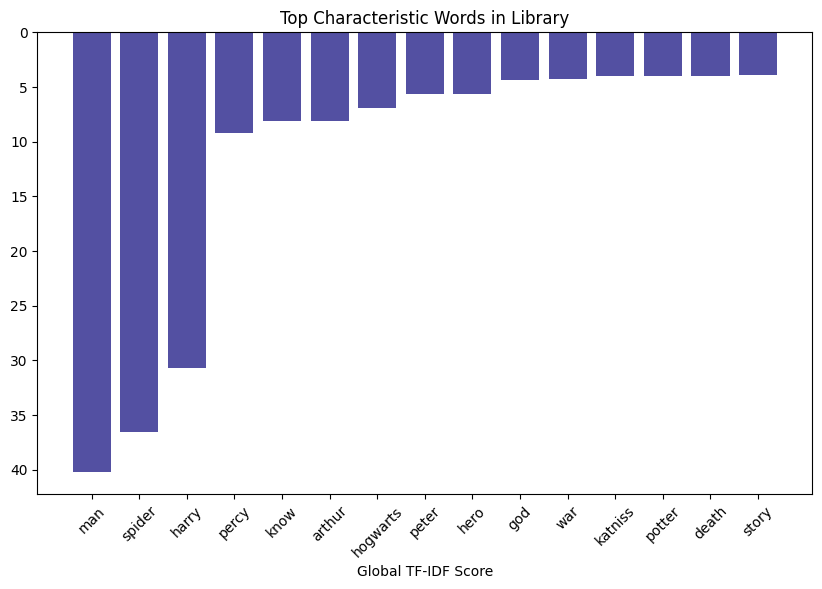

In [106]:
def plot_aggregate(top_characteristic_words = top_characteristic_words, file_name="overall.png"):
    """Plot Bar Graph of most important words using aggregated tf idf scores"""
    words, scores = zip(*top_characteristic_words)
    fig = plt.figure(figsize=(10, 6))
    plt.bar(words, scores, color="#5350a2")
    plt.xlabel("Global TF-IDF Score")
    plt.title("Top Characteristic Words in Library")
    plt.gca().invert_yaxis()
    plt.xticks(rotation = 45)
    plt.show()
    fig.savefig(file_name, transparent=True)

plot_aggregate(top_characteristic_words)


# Clustering of Books

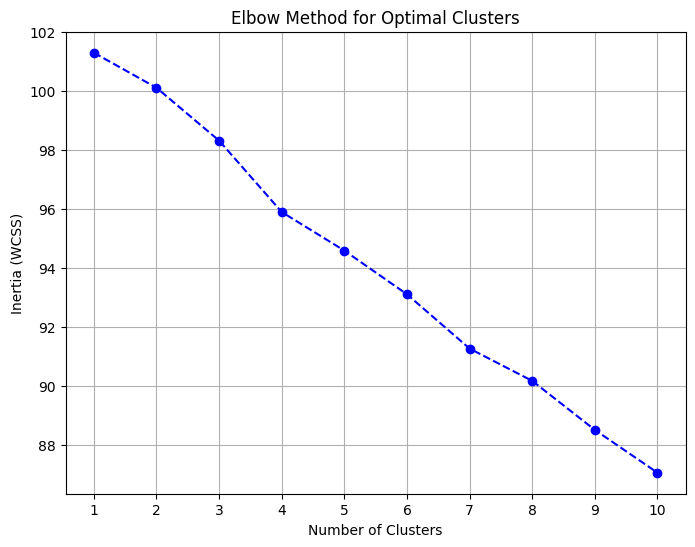

In [107]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--', color='b')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (WCSS)")
plt.xticks(cluster_range)
plt.grid()
plt.savefig('elbow.png', transparent = True)
plt.show()

In [108]:


def cluster_books(descriptions, num_clusters = 4, tfidf_matrix = tfidf_matrix):
    """Cluster books based on descriptions"""
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)

    # Assign cluster labels to each book
    cluster_labels = kmeans.labels_

    # Create a DataFrame with titles and cluster labels
    books_df = pd.DataFrame({
        "Title": descriptions.keys(),
        "Cluster": cluster_labels
    })

    return(books_df, cluster_labels)

books_df, cluster_labels = cluster_books(descriptions)


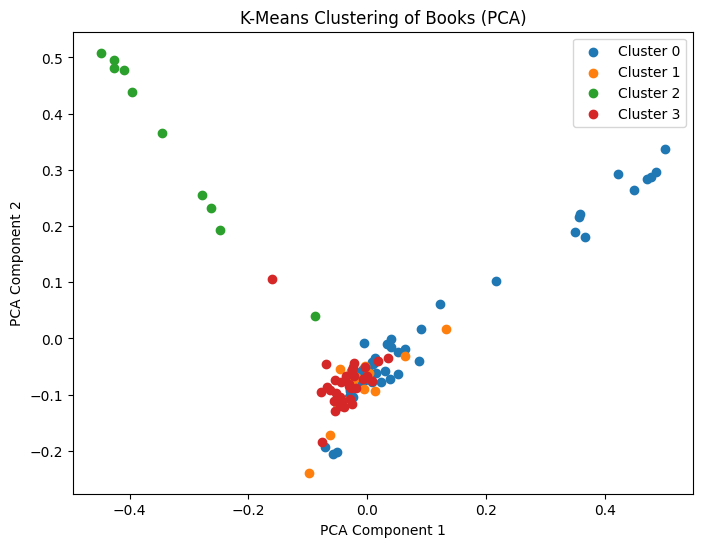

In [109]:

# Reduce TF-IDF matrix to 2D using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf_matrix.toarray())

def plot_clusters(tfidf_2d = tfidf_2d, num_clusters=4):
    """Plots clusters from 2d decomposition"""
    # Plot clusters
    plt.figure(figsize=(8, 6))
    for cluster in range(num_clusters):
        cluster_points = tfidf_2d[cluster_labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    plt.title("K-Means Clustering of Books (PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.savefig('pca.png', transparent=True)
    plt.show()

plot_clusters(tfidf_2d, 4)


In [110]:
books_df.to_csv('clusters.csv', index=False)

In [111]:
from wordcloud import WordCloud

In [112]:
books_df[books_df['Cluster'] == 2]['Title']

5              Harry Potter and the Philosopher’s Stone
6              Harry Potter and the Prisoner of Azkaban
10                 Harry Potter and the Deathly Hallows
15                  Harry Potter and the Goblet of Fire
30            Harry Potter and the Order of the Phoenix
49              Harry Potter and the Chamber of Secrets
57                         The Tales of Beedle the Bard
59               Harry Potter and the Half-Blood Prince
74    Harry Potter and the Cursed Child: Parts One a...
85          Harry Potter and the Methods of Rationality
Name: Title, dtype: object

# Clustered Heatmaps to show most important words in each found cluster

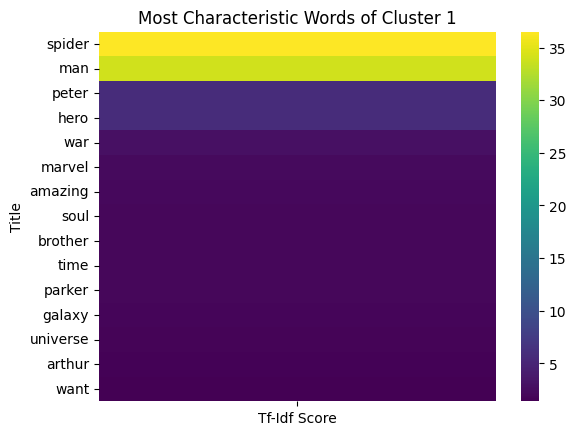

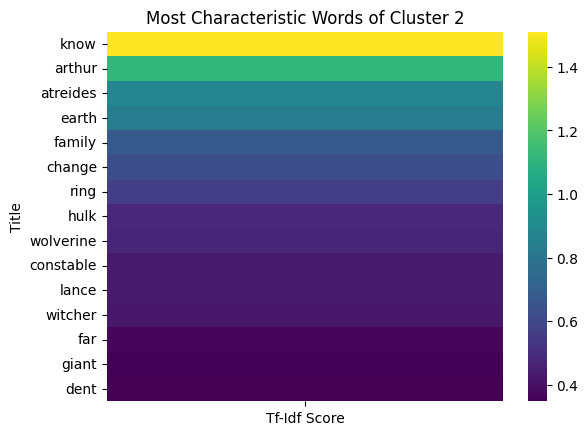

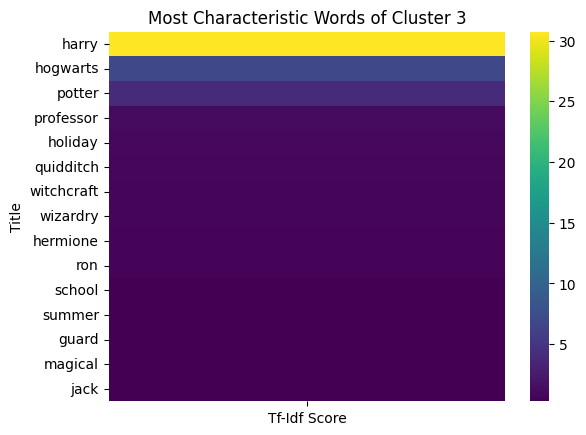

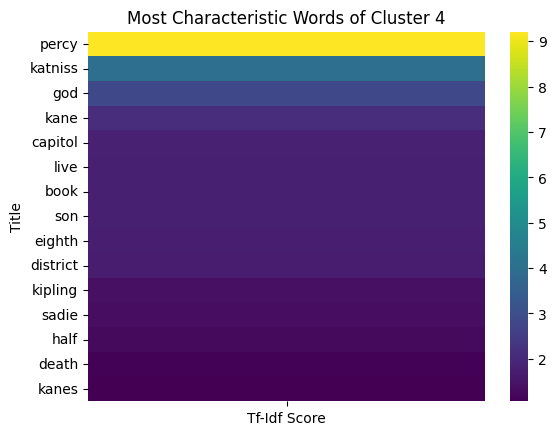

In [128]:
plt.clf()
clustered = pd.DataFrame(top_words_per_description)
clustered = clustered.join(books_df.set_index('Title'), on="title")
clustered.set_index('title', inplace = True)


for i in range(4):
    # Converts top library words output to dataframe for heatmap
    sns.heatmap(pd.DataFrame(top_library_words(clustered[clustered['Cluster'] == i].to_dict(orient="records")), columns=['Title', 'Tf-Idf Score']).set_index('Title'), cmap="viridis", cbar="True")
    plt.title(f"Most Characteristic Words of Cluster {i+1}")
    plt.savefig(f"cluster_{i}", transparent=True)
    plt.show()
#     sns.heatmap(top_library_words(clustered[clustered['Cluster'] == i].to_dict(orient="records")))
#     #plot_aggregate(top_library_words(clustered[clustered['Cluster'] == i].to_dict(orient="records")), f"cluster_{i}.png")